# Linear mixed-effects models with Professor Mittens

In this document we will look at linear mixed-effects models (LMM). Note that these models have many names, but for this notebook we will attempt to follow the nomenclature of the course textbook, Fox (2015). This notebook uses an R kernel with and makes use of the `lme4` package to do the actual model fitting.

In [1]:
library(dplyr)
library(purrr)
library(magrittr)
library(ggplot2)
library(lme4)
library(MuMIn)

set.seed(1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


Loading required package: Matrix



## Exploratory data analysis

The data used here are time series of the weights of cats. These are stored in `cat-weight-by-breed.csv` which has the following columns:

- `breed` the breed of the cat,
- `weight` the weight of the cat in kilograms,
- `age` the age of the cat when it was weighed,
- `id` an integer identifier so we can link measurements through time.

Since there are many cats represented here, to simplify the analysis model checking we will also take a sample of `id` values to look at. These are stored in the variable `.id_sample`. We will not be making use of the `breed` variable here, but it is included in case you want to try a 3 level model as an extension.

**The main question that we are interesting in answering is how the age of a cat influences its weight.**

In [2]:
CAT_DF <- read.csv("cat-weights-by-breed.csv", sep = " ")

.id_sample <- sample(unique(CAT_DF$id), size = 12)

head(CAT_DF)

,breed,weight,age,id
,<chr>,<dbl>,<int>,<int>
1,abyssinian,7.582107,1,1
2,abyssinian,8.517379,2,1
3,abyssinian,7.975433,3,1
4,abyssinian,8.711454,4,1
5,abyssinian,9.452751,5,1
6,abyssinian,9.555820,6,1


The first thing we will do is to plot the time series for all of the cats and to display the average behaviour on top of this. Note that there is not the same number of measurements for each of the cats, the last age at which the cat was measured differs between the cats.

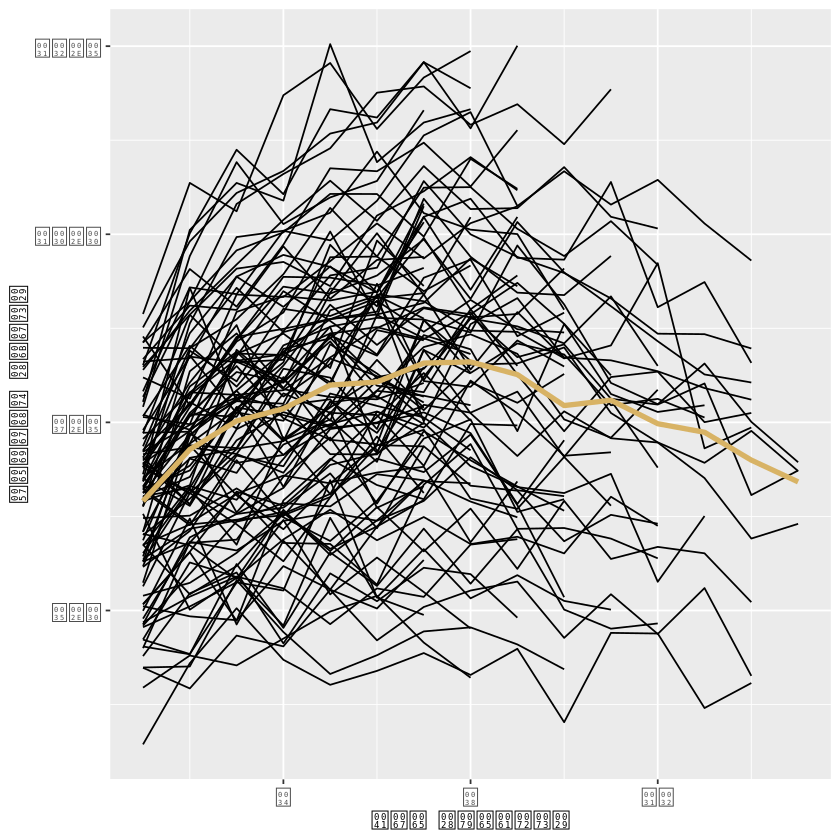

In [3]:
HEX_CODES <- c("#d8b365", "#5ab4ac")
LINE_SIZE <- 1.5

.plot_df <- CAT_DF %>% group_by(age) %>% summarise(mean_weight = mean(weight))

g0 <- ggplot(CAT_DF) +
  geom_line(aes(x = age, y = weight, group = id)) +
  geom_line(data = .plot_df, mapping = aes(x = age, y = mean_weight), colour = HEX_CODES[1], size = LINE_SIZE) +
  theme_grey() +
  labs(x = "Age (years)", y = "Weight (kgs)")

g0

We can then drill into the time series of a selection of the cats to see that these look like individually.

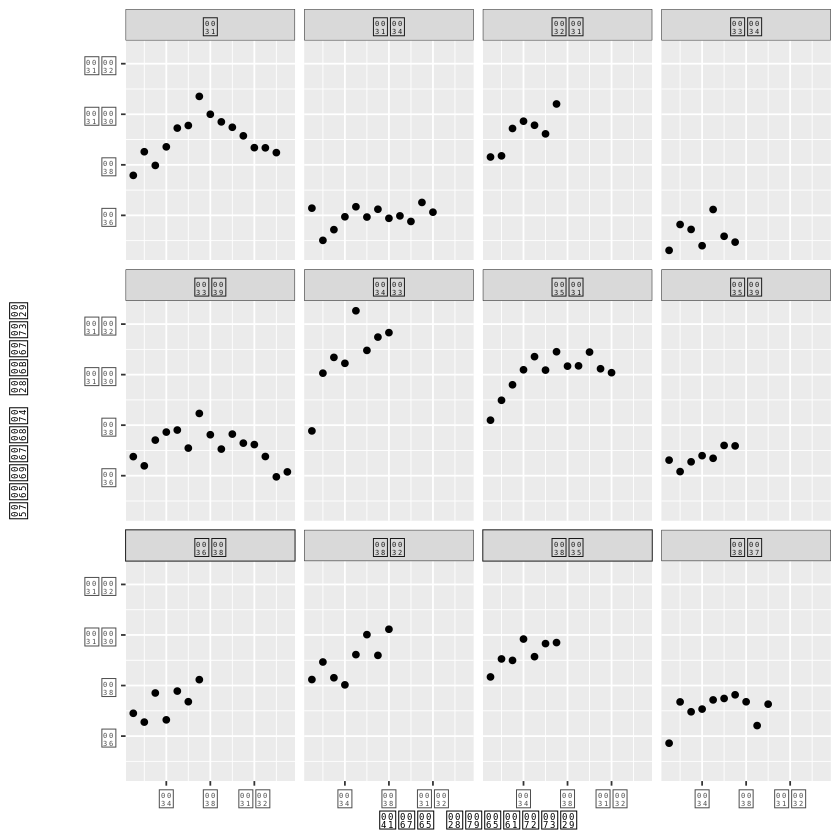

In [4]:
g1 <- ggplot(filter(CAT_DF, is.element(id, .id_sample)), aes(x = age, y = weight, group = id)) +
  geom_point() +
  facet_wrap(~id) +
  theme_grey() +
  labs(x = "Age (years)", y = "Weight (kgs)")

g1

## Question

Looking at this set of the time series, what do you observe about the weights in the time series? Does the (time-)average differ between cats? What is the overall shape?

## Partial answer

- There appears to be a non-linear relationship between age and weight.
- There is a substantial amount of difference in the initial weights of the cats.
- The between cat variability is substantially greater than the variability within each set of measurements.

## Ordinary linear regression

The code in the following cell is a little complicated, but basically it fits a quadratic function to the weights of each cat as a linear model.

## Question

Given the observations we have just made, what is a sensible formula for a linear model at the individual level?

## Partial answer

`weight ~ poly(age, 2, raw = TRUE)` 

Keep in mind that we need to set `raw=TRUE` for this to have the natural interpretation.

In [5]:
summarise_fit_factory <- function(summary_func) {
  function(id_num) {
    fit <- lm(weight ~ poly(age, 2, raw = TRUE),
      data = CAT_DF[CAT_DF$id == id_num, ]
    )
    summary_func(fit)
  }
}
demo_coefs <- summarise_fit_factory(coef)
demo_fit <- summarise_fit_factory((function(x) x$fit))

individual_model_coefs <- map(
  .x = unique(CAT_DF$id),
  .f = demo_coefs
) %>% map(compose(as.data.frame, t)) %>% bind_rows

individual_model_fits <- map(
  .x = unique(CAT_DF$id),
  .f = function(x) {
    data.frame(age = CAT_DF[CAT_DF$id == x, "age"], weight_fit = demo_fit(x), id = x)
  }
) %>% bind_rows()

We can plot the coefficients that were estimated for each of the linear models as a pairs plot to see how the fits vary across the cats.

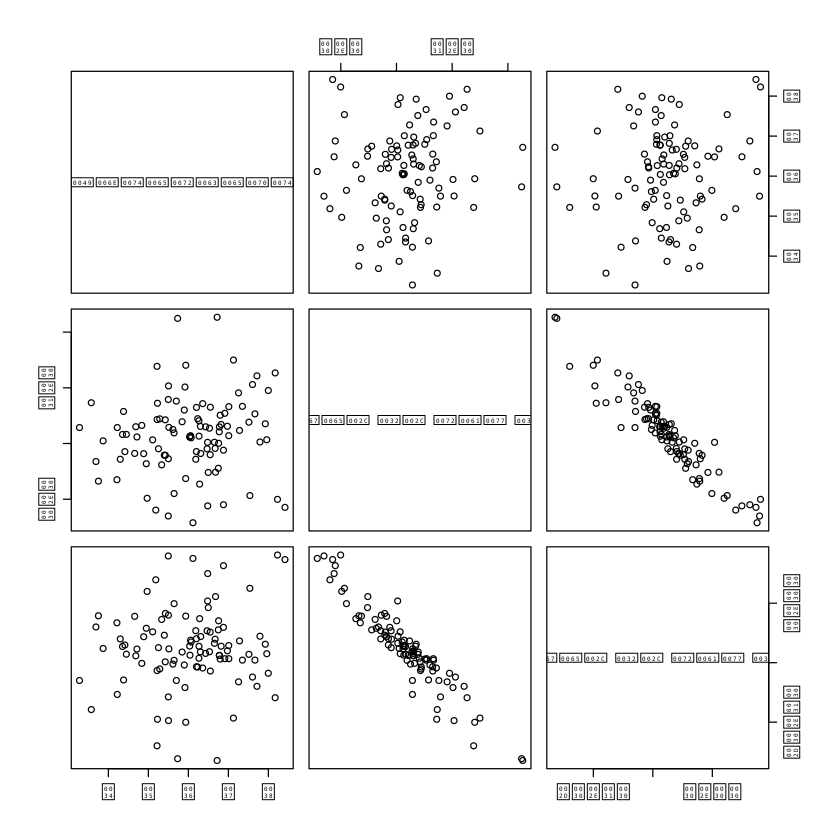

In [6]:
individual_model_coefs %>% pairs

We can evaluate the model fits for the subset of the cats to see how the model fits these data.

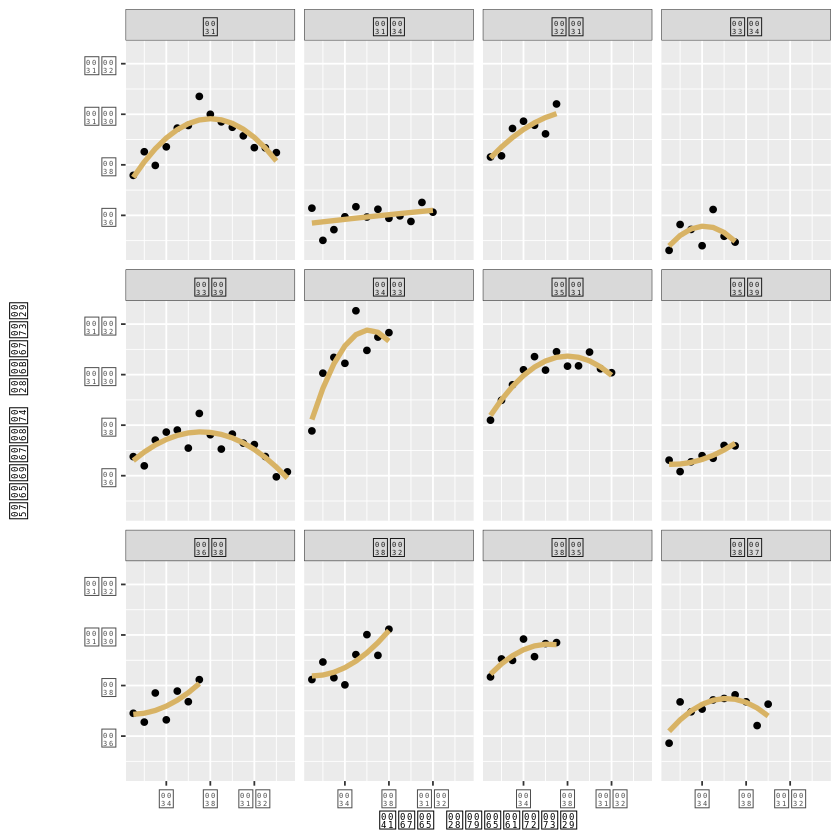

In [7]:
g2 <- g1 +
  geom_line(
    data = filter(individual_model_fits, is.element(id, .id_sample)),
    mapping = aes(x = age, y = weight_fit, group = id),
    size = LINE_SIZE,
    colour = HEX_CODES[1]
  ) + facet_wrap(~id)
                                   
g2

## Question

Does anything about the estimated coefficients concern you? Does anything the model fits look a little bit concerning?

## Partial answer

- There is a strong correlation in the estimates of the quadratic coefficients which suggests these may be challenging to estimate.
- While most of the fits suggest a concave mean weight through time, in a few cases the quadratic is convex!

## LMM formulation

We will now consider a LMM for this data. We will start with a more natural formulation, and then translate it into a form that can be understood by `lme4`. If you want to use LMM in practice you will probably need to go through this process yourself!

$$
k_{ij} = \alpha_{0i} + \alpha_{1i} t_{ij} +\alpha_{2i} t_{ij}^2 + \epsilon_{ij}
$$

where $k_{ij}$ is the weight of cat $i$ at measurement number $j$, the variable $t_{ij}$ is the age of cat $i$ at measurement number $j$ and $\epsilon_{ij}$ is random measurement error.

We can consider the peculiarities of each cat by expressing these coefficients themselves as random variables: $\alpha_{li} = \gamma_{l} + \omega_{li}$. Then, we can re-express this model in terms of fixed and random effects as follows:

$$
k_{ij} = \gamma_{0} + \gamma_{1} t_{ij} +\gamma_{2} t_{ij}^2 + \omega_{0i} + \omega_{1i} t_{ij} +\omega_{2i} t_{ij}^2 + \epsilon_{ij}
$$

We are now in a good position to fit this model with `lme4`. Note that to indicate the random effects are indexed by `id` there is the additional syntax `(var | factor)`.

## Question

Why are we using a quadratic model here? What is the danger in doing this?

## Partial answer

- We are using a quadratic model because it is clear from the data that there is a non-linear response.
- It is dangerous because higher degree polynomials are more susceptible to gross errors upon extrapolation than linear models.

In [8]:
quadratic_model <- lmer(weight ~ poly(age, 2, raw = TRUE) + (poly(age, 2, raw = TRUE) | id),
  data = CAT_DF
)

boundary (singular) fit: see ?isSingular



Before we go onto study the fit in detail, let's just plot the fitted values for the same subset of cats as before. Note that those cats that previously had a convex fit, now have a concave one. This is because the fixed effects are shared across the time series which allows the general trend to dominate the stochastic effects for those short time series.

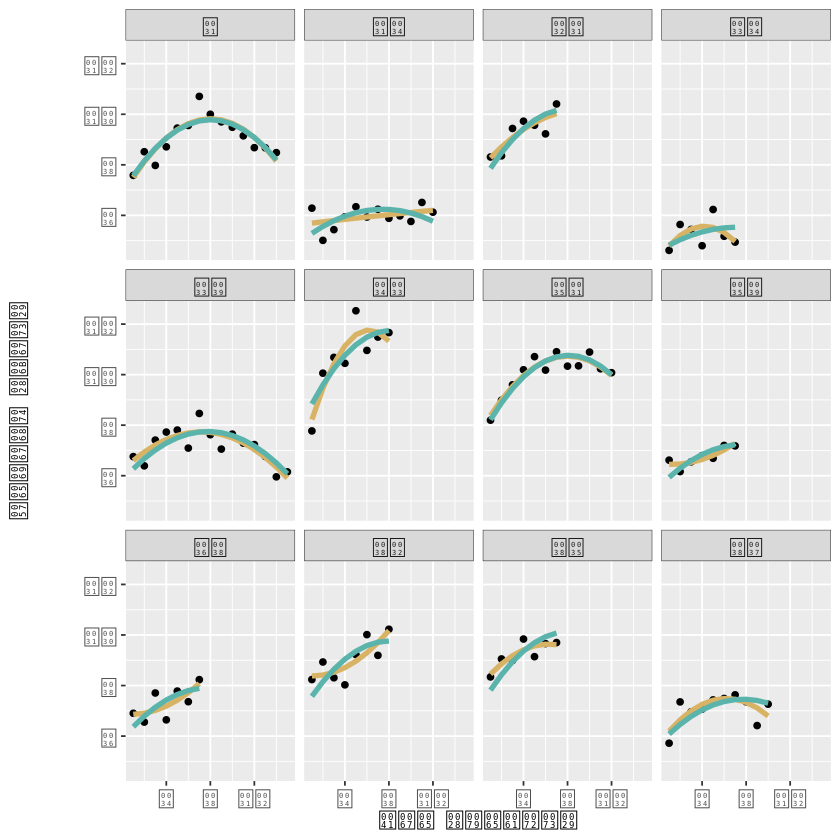

In [9]:
cat_df_with_lme_fit <- CAT_DF
cat_df_with_lme_fit$fit <- fitted(quadratic_model)

g3 <- g2 + geom_line(
  data = filter(cat_df_with_lme_fit, is.element(id, .id_sample)),
  mapping = aes(x = age, y = fit, group = id),
  size = LINE_SIZE,
  colour = HEX_CODES[2]
)

g3

## Question

Wow, wow, wow! Slow down there, why do the fitted values look different for each time series?

## Partial answer

This question refers to the fact that if we only considered the estimates based on the fixed effects, the fitted values would look the same for all the cats. The fitted values differ because estimates of the random effects are used. The details of how this is done go beyond the scope of this course, but you can take comfort in the fact that these fitted values are the *best linear unbiased predictors* (BLUPs). If you want more details on this you can see Section 23.8 of Fox (2015).

In [10]:
summary(quadratic_model)

Linear mixed model fit by REML ['lmerMod']
Formula: weight ~ poly(age, 2, raw = TRUE) + (poly(age, 2, raw = TRUE) |  
    id)
   Data: CAT_DF

REML criterion at convergence: 1718

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1719 -0.6645 -0.0025  0.6533  3.0455 

Random effects:
 Groups   Name                      Variance  Std.Dev. Corr       
 id       (Intercept)               1.0692460 1.03404             
          poly(age, 2, raw = TRUE)1 0.0397990 0.19950   0.99      
          poly(age, 2, raw = TRUE)2 0.0001327 0.01152  -0.99 -1.00
 Residual                           0.2035390 0.45115             
Number of obs: 971, groups:  id, 100

Fixed effects:
                           Estimate Std. Error t value
(Intercept)                6.064956   0.112971   53.69
poly(age, 2, raw = TRUE)1  0.556053   0.025412   21.88
poly(age, 2, raw = TRUE)2 -0.035328   0.001652  -21.39

Correlation of Fixed Effects:
              (Intr) p(,2,r=TRUE)1
p(,2,r=TRUE)1  0.488        

## Question

Explain what these coefficients tell us about the average weight of a cat as it gets older?

## Partial answer

The weight follows a concave function.

## Question

What do you notice about the correlations in the parameters of the random effects? How might you have guessed that this sort of correlation would be present?

## Partial answer

We observed similar correlation when fitting a model to each time series individually.

## Diagnostics and model fit

We can plot the residuals against the fitted values to look for systematic errors in the model fit. 

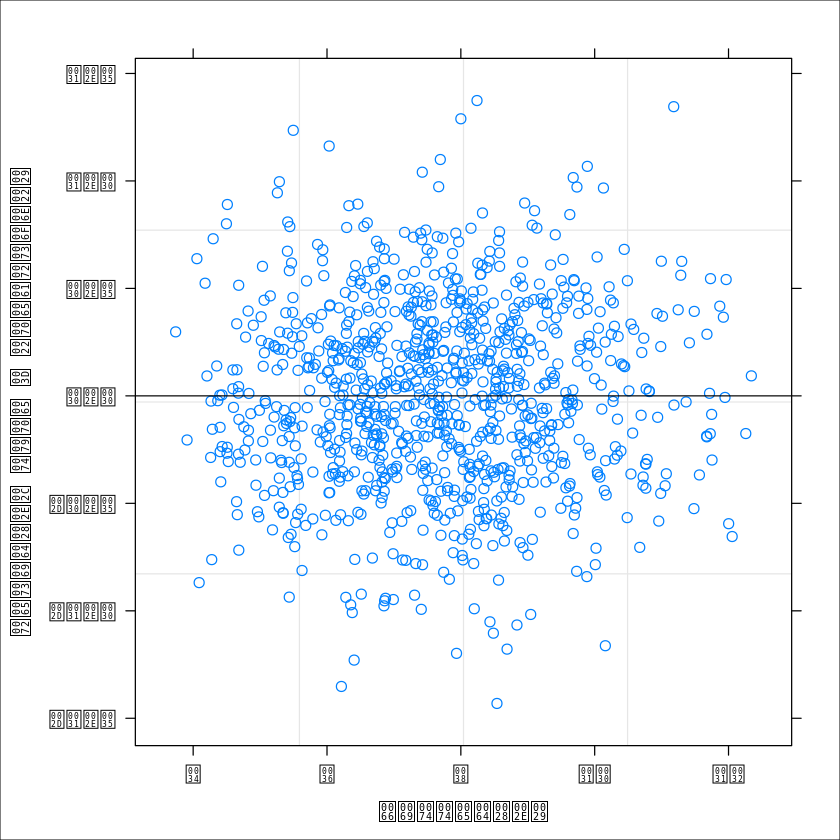

In [11]:
plot(quadratic_model)

Although the standard deviations and the estimates of the fixed effects are given in the summary of the model fit, there can be correlations which mean that we might want to use a more sophisticated method to estimate the CI. Here we will just use the Wald method to generate the CI which does not correct for this sort of error, but if you look up the documentation of `confint.merMod` it will list the available methods.


In [12]:
confint.merMod(quadratic_model, "poly(age, 2, raw = TRUE)1", method = "Wald")

,2.5 %,97.5 %
"poly(age, 2, raw = TRUE)1",0.5062466,0.6058588


The `MuMIn` package provides a helper function to compute an analogue of $R^2$ for generalised LMMs. There are two values returned, the first is the *marginal* $R^2$, which is the variability explained by the fixed effects alone, and then there is the *conditional* $R^2$ which reports the variability explained by both fixed and random effects. The stark difference between the $R^2$ values suggests that a large amount of  the variability is due to the random effects. This may not have been easy to see looking at the coefficients reported by the summary alone!


In [13]:
r.squaredGLMM(quadratic_model)

Warning message:
“'r.squaredGLMM' now calculates a revised statistic. See the help page.”


R2m,R2c
0.09091203,0.9386407
